In [1]:
from model_manager import section1, section2, single_model
import optimizer as opt

Num GPUs Available:  1


In [2]:
main_folder = '../'
dataset1_folder = main_folder + 'dataset_tfrecord_small' + '/'
dataset2_folder = main_folder + 'dataset2_small' + '/'
checkpoints_sect1 = main_folder + 'checkpoints_sect1' + '/'

In [3]:
import dataset_creator

dataset1_generator = dataset_creator.Dataset1()
dataset1_generator = dataset1_generator.generate_dataset(dataset1_folder + 'coords.tfrecord',
                                                         dataset1_folder + 'coords_test.tfrecord',
                                                         dataset1_folder + 'train.tfrecord',
                                                         dataset1_folder + 'test.tfrecord'
                                                         )

Iteration: 0/10
Training model with: [64, 80, 150, 48], [50, 512, 220]
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)


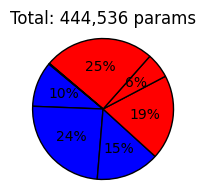

Epoch 21/120 - loss: 24.3682 - mean_absolute_error: 3.7445 - val_loss: 13.9326 - val_mean_absolute_error: 2.82352227
Target MAE of 3 reached! Stopping training.

Training time: 54.9s
The history has the following data:  dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


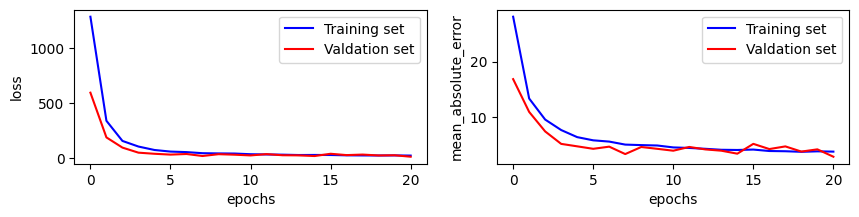

Iteration: 1/10
Training model with: [61, 74, 151, 35], [42, 363, 170]
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)


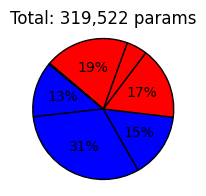

Epoch 66/120 - loss: 38.9073 - mean_absolute_error: 4.6706 - val_loss: 13.9538 - val_mean_absolute_error: 2.67601155
Target MAE of 3 reached! Stopping training.

Training time: 155.8s
The history has the following data:  dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


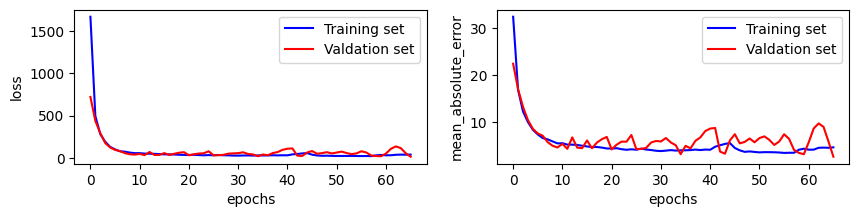

Iteration: 2/10
Training model with: [54, 57, 136, 34], [29, 356, 160]
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)


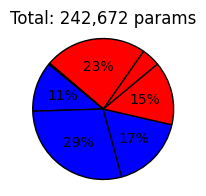

Epoch 45/120 - loss: 42.1085 - mean_absolute_error: 4.8832 - val_loss: 16.2308 - val_mean_absolute_error: 2.80791640
Target MAE of 3 reached! Stopping training.

Training time: 85.6s
The history has the following data:  dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


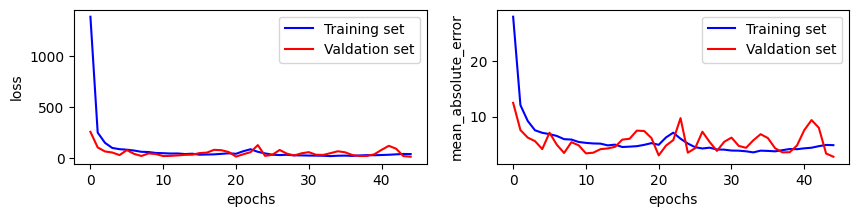

Iteration: 3/10
Training model with: [44, 47, 111, 26], [20, 306, 118]
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)


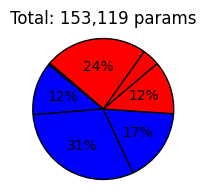

Epoch 120/120 - loss: 28.0421 - mean_absolute_error: 3.8291 - val_loss: 35.4746 - val_mean_absolute_error: 4.3953824
Training time: 188.5s
The history has the following data:  dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


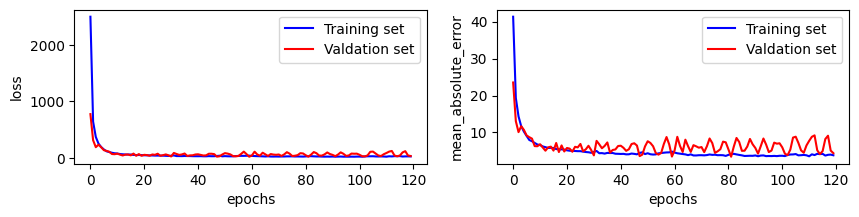

Target value not reached, attempt: 1
Iteration: 4/10
Training model with: [44, 38, 85, 18], [18, 296, 123]
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)
Image batch shape: (128, 128, 128, 1)
Label batch shape: (128, 2)


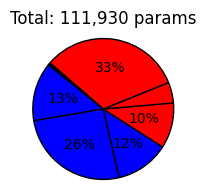

Epoch 33/120 - loss: 38.3805 - mean_absolute_error: 4.5494 - val_loss: 64.2567 - val_mean_absolute_error: 6.48704989

In [ ]:
conv_layers = [64,80,150,48]
dense_layers = [50,512,220]
target = 3
model = section1()
optimizer = opt.Optimizer()
best_conv, best_dense, iter_num = optimizer.optimize(model=model, conv_layers=conv_layers, dense_layers=dense_layers, target=target, max_iter=10, random_factor=(0.7, 1.05), max_failed_trains=2)

In [ ]:
dataset2_gen = dataset_creator.Dataset2(weights=checkpoints_sect1 + 'modelfinal08.weights.h5')
dataset2_gen.generate_dataset(dataset1_folder + 'train.tfrecord',
                              dataset1_folder + 'test.tfrecord',
                              dataset2_folder + 'train_cropped.tfrecord',
                              dataset2_folder + 'test_cropped.tfrecord'
                              )

In [ ]:
dataset_folder = 'dataset2_small'
model = section2(dataset_folder=dataset_folder)
model.initialise_data_and_model()
model.train()

In [ ]:
model.plot()

In [ ]:
conv_layers = [64,80,150,48]
dense_layers = [50,512,220]
target = 3
model = section1()
best_conv, best_dense, iter_num = optimize(model=model, conv_layers=conv_layers, dense_layers=dense_layers, target=target, max_iter=10, random_factor=(0.7, 1.05), max_failed_trains=2)

In [ ]:
print(best_conv, best_dense, iter_num)

In [ ]:
weights_folder = '../checkpoints_sect1/'
eval_model = section1()
eval_model.initialise_data_and_model(conv_layers=best_conv, dense_layers=best_dense)
eval_model.model.load_weights(weights_folder + f'modelweights_{iter_num}.weights.h5')

In [ ]:
eval_model.eval_random()